## Fine-tuning with chainer

In this example, we're going to fit the trained model to another dataset called 'fine tuning' or 'transfer learning'.  
Download the 'CaffeNet' model file and set the correct paths to these files.  
* caffemodel: https://github.com/BVLC/caffe/tree/master/models/bvlc_reference_caffenet  
* meanfile: https://github.com/BVLC/caffe/tree/master/python/caffe/imagenet 

In [1]:
path_to_model = 'bvlc_reference_caffenet.caffemodel'
path_to_mean = 'ilsvrc_2012_mean.npy'

We'll also use the oxford 17 category flower dataset.  
Download '1. Dataset images' from the following URL, extract 'jpg' directory and set the correct path.   
* http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

In [2]:
path_to_dataset = 'jpg/'

CaffeNet uses the mean subtracted images so that the prediction accuracy of the network improves. We should subtract the pre-computed mean value from every color channel before training.

In [3]:
import numpy as np
np.random.seed(0)
mean = np.load(path_to_mean).mean(1).mean(1)
print mean # BGR order

[ 104.00698793  116.66876762  122.67891434]


Take care that CaffeNet uses images which shape is 3x227x227, the each value ranges from 0 to 255, the mean subtracted and BGR order not RGB.

In [4]:
import skimage as ski
from skimage import io, transform
    
def improcess(path_to_im):
    im = ski.io.imread(path_to_im)
    im = ski.transform.resize(im, (227,227)) # input shape in CaffeNet
    im = im.transpose(2,0,1) # in order (color, height, width)
    im *= 255 # range from 0 to 255
    im = im[[2,1,0], :, :] # RGB to BGR order
    im -= mean[:, np.newaxis, np.newaxis] # subtract mean
    return im.astype(np.float32)

def imdeprocess(data):
    im = data + mean[:, np.newaxis, np.newaxis]
    im = im[[2,1,0], :, :]
    im /= 255
    im = im.transpose(1,2,0)
    return im

Load the dataset and pre-process the images.

In [5]:
import os 
filenames = np.loadtxt(path_to_dataset +'files.txt', dtype=str)

train_data = []
train_labels = []
test_data = []
test_labels = []
label = -1

for i,filename in enumerate(filenames):
    im = improcess(path_to_dataset + filename)
    if i % 80 == 0: 
        perm = np.random.permutation(80)
        label += 1
    if perm[i%80] < 40:
        train_data.append(im)
        train_labels.append(label)
    else:
        test_data.append(im)
        test_labels.append(label)

# shuffle the data for training
perm = np.random.permutation(len(train_data))
train_labels = np.array(train_labels).astype(np.int32)[perm]
train_data = np.array(train_data)[perm]

# shuffle the data for test
perm = np.random.permutation(len(test_data))
test_labels = np.array(test_labels).astype(np.int32)[perm]
test_data = np.array(test_data)[perm]

label_names = ['Buttercup', 'Colls\' Foot', 'Daffodil', 'Daisy', 'Dandelion',
               'Fritillary', 'Iris', 'Pansy', 'Sunflower', 'Windflower', 'Snowdrop',
              'Lily Valley', 'Bluebell', 'Crocus', 'Tigerlily', 'Tulip', 'Cowslip']

Let's take a look at some data in the dataset.

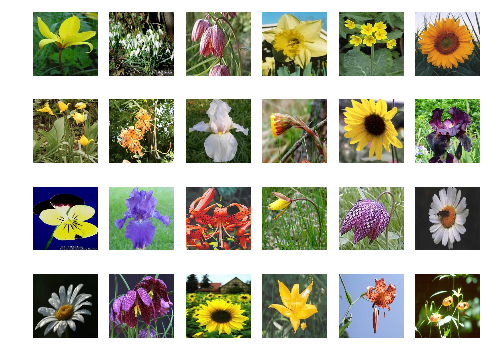

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8,6))
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]))

The oxford 17 category flower dataset includes 80 images per category. Now we devided it in half (for training and test).

In [7]:
N = train_labels.shape[0]
N_test = test_labels.shape[0]
print 'data for training: ' + str(N)
print 'data for test: ' + str(N_test)

data for training: 680
data for test: 680


Import chainer and the dependencies.

In [8]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

If you use a gpu, set the gpu device value here.

In [9]:
gpu = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpu >= 0 else np

Import the CaffeNet model to chainer (may take a few minutes).

In [10]:
import chainer.functions.caffe
caffefunc = chainer.functions.caffe.CaffeFunction(path_to_model)

We'll get the same prediction as the following caffe tutorial.  
http://nbviewer.ipython.org/github/bvlc/caffe/blob/master/examples/00-classification.ipynb
* cat.jpg: https://github.com/BVLC/caffe/blob/master/examples/images/cat.jpg

Predicted class is #285.


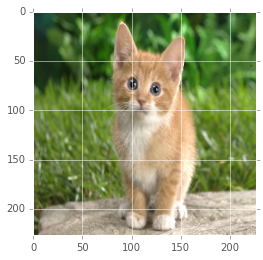

In [11]:
plt.imshow(imdeprocess(improcess('cat.jpg')))
x = chainer.Variable(improcess('cat.jpg')[np.newaxis,:])
fc8, = caffefunc(inputs={'data': x}, outputs=['fc8'])
y = F.softmax(fc8)
print("Predicted class is #{}.".format(y.data.argmax()))

Finally, let's start fine-tuing.  
Define the architecture of the CNN, and copy parameters from the CaffeNet.  

In [12]:
class CNN(chainer.Chain):
    
    def __init__(self):
        self.caffe = chainer.Chain(
            conv1 = L.Convolution2D(3, 96, ksize=11, stride=4),
            conv2 = L.Convolution2D(96, 256, ksize=5, pad=2),
            conv3 = L.Convolution2D(256, 384, ksize=3, pad=1),
            conv4 = L.Convolution2D(384, 384, ksize=3, pad=1),
            conv5 = L.Convolution2D(384, 256, ksize=3, pad=1),
            fc6 = L.Linear(9216, 4096),
            fc7 = L.Linear(4096, 4096),
        )
        self.fine = chainer.Chain(
            fc8_fine = F.Linear(4096, 17),
        )
        
    def __call__(self, x, t, train=True):
        self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(self.y, t)
        self.accuracy = F.accuracy(self.y, t)
        return self.loss
    
    def forward(self, x, train=False):
        self.x = x
        self.conv1 = F.relu(self.caffe.conv1(x))
        self.pool1 = F.max_pooling_2d(self.conv1, ksize=3, stride=2)
        self.norm1 = F.local_response_normalization(self.pool1,
                            k=5, n=5, alpha=0.0001, beta=0.75)*np.power(5, 0.75)
        self.conv2 = F.relu(self.caffe.conv2(self.norm1))
        self.pool2 = F.max_pooling_2d(self.conv2, ksize=3, stride=2)
        self.norm2 = F.local_response_normalization(self.pool2,
                            k=5, n=5, alpha=0.0001, beta=0.75)*np.power(5, 0.75)
        self.conv3 = F.relu(self.caffe.conv3(self.norm2))
        self.conv4 = F.relu(self.caffe.conv4(self.conv3))
        self.conv5 = F.relu(self.caffe.conv5(self.conv4))
        self.pool5 = F.max_pooling_2d(self.conv5, ksize=3, stride=2)
        self.fc6 = F.dropout(F.relu(self.caffe.fc6(self.pool5)), train=train)
        self.fc7 = F.dropout(F.relu(self.caffe.fc7(self.fc6)), train=train)
        self.y = self.fine.fc8_fine(self.fc7)
        return self.y

In [13]:
model = CNN()
model.caffe.conv1.copyparams(caffefunc.conv1)
model.caffe.conv2.copyparams(caffefunc.conv2)
model.caffe.conv3.copyparams(caffefunc.conv3)
model.caffe.conv4.copyparams(caffefunc.conv4)
model.caffe.conv5.copyparams(caffefunc.conv5)
model.caffe.fc6.copyparams(caffefunc.fc6)
model.caffe.fc7.copyparams(caffefunc.fc7)

We modified LRN (local response normalization) layers, because LRN in caffe implementation is different from one in chainer. Here we set $k=n$ and multiply the LRN outputs by $n^\beta$.  
 
* Chainer  
$y_i=\displaystyle \frac{x_i}{(k+\alpha \sum_{j=max(0,i-n/2)}^{min(N-1,i+n/2)} x_j^2)^\beta}$  
* Caffe  
$y_i=\displaystyle \frac{x_i}{(1+\alpha/n \sum_{j=max(0,i-n/2)}^{min(N-1,i+n/2)} x_j^2)^\beta}$

Set the optimizer. We should drop the learning rate in trained layers because they need less tuning than initialized layers. The learning rate of the CaffeNet have been already dropped by $10^{-4}$ after 450,000 iterations. We can train only the last layer is another way if you want to get the training converged faster.

In [14]:
opt_caffe = chainer.optimizers.Adam(alpha=1e-7) # default:1e-3
opt_caffe.setup(model.caffe)
opt_fine = chainer.optimizers.Adam()
opt_fine.setup(model.fine)
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.caffe.to_gpu()
    model.fine.to_gpu()
batchsize = 20

Define a function to evalute the net.

In [15]:
import sys
import progressbar as prg
losses, test_its, test_losses, test_accs = ([] for i in range(4))
def test(x, y):
    sum_accuracy = 0
    sum_loss = 0
    with prg.ProgressBar(max_value=len(y)) as bar:
        for i in six.moves.range(0, len(y), batchsize):
            x_batch = chainer.Variable(
                xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(
                xp.asarray(y[i:i + batchsize]), volatile='on')
            model.test(x_batch, t_batch, train=False)
            sum_loss += float(model.loss.data) * len(t_batch)
            sum_accuracy += float(model.accuracy.data) * len(t_batch)
            bar.update(i)
    sys.stderr.flush()
    test_its.append(len(losses))
    loss = sum_loss/len(y)
    accuracy = sum_accuracy /len(y)
    test_losses.append(loss)
    test_accs.append(accuracy)
    return loss, accuracy

In [16]:
loss, acc = test(test_data, test_labels)
print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))

100% (680 of 680) |###########################| Elapsed Time: 0:00:01 Time: 1.07


test: loss=3.82441154648, accuracy=0.0338235299158


Train the model by forward and backward computations.

In [17]:
n_epoch = 10

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    perm = np.random.permutation(N)
    with prg.ProgressBar(max_value=N) as bar:
        for i in six.moves.range(0, N, batchsize):
            x = chainer.Variable(
                xp.asarray(train_data[perm[i:i + batchsize]]),  volatile='off')
            t = chainer.Variable(
                xp.asarray(train_labels[perm[i:i + batchsize]]),  volatile='off')
            opt_fine.zero_grads()
            opt_caffe.zero_grads()
            loss = model(x, t)
            loss.backward()
            opt_fine.update()
            opt_caffe.update()
            losses.append(float(model.loss.data))
            sys.stderr.write(' Loss: {}'.format(str(float(model.loss.data))))
            bar.update(i)
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    print('train: batch={}, loss={}'.format(
        str(i/batchsize+1), str(float(model.loss.data))))
    print ('test: loss={}, accuracy={}'.format(str(loss), str(acc)))
    sys.stdout.flush()
    
# save model
serializers.save_hdf5('cnn-finetuning-caffe.chainermodel', model.caffe)
serializers.save_hdf5('cnn-finetuning-fine.chainermodel', model.fine)

100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.71
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 1)
train: batch=34, loss=0.514182806015
test: loss=0.559387255241, accuracy=0.807352939073


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.48
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 2)
train: batch=34, loss=0.436297804117
test: loss=0.388189338476, accuracy=0.864705886911


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.48
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 3)
train: batch=34, loss=0.544855892658
test: loss=0.407147809425, accuracy=0.852941176471


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.48
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 4)
train: batch=34, loss=0.469485372305
test: loss=0.305608315393, accuracy=0.892647054266


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.48
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 5)
train: batch=34, loss=0.467117607594
test: loss=0.317650885376, accuracy=0.8897058806


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.49
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.62


('epoch', 6)
train: batch=34, loss=0.540711820126
test: loss=0.306273692452, accuracy=0.886764701675


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.50
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 7)
train: batch=34, loss=0.346596211195
test: loss=0.306669824702, accuracy=0.886764701675


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.50
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 8)
train: batch=34, loss=0.400287359953
test: loss=0.301210486494, accuracy=0.889705884106


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.46
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.61


('epoch', 9)
train: batch=34, loss=0.283642292023
test: loss=0.287483959733, accuracy=0.892647057772


100% (680 of 680) |###########################| Elapsed Time: 0:00:02 Time: 2.53
100% (680 of 680) |###########################| Elapsed Time: 0:00:00 Time: 0.63


('epoch', 10)
train: batch=34, loss=0.445481538773
test: loss=0.338279067457, accuracy=0.901470584028


Plot the losses and the accuracies.

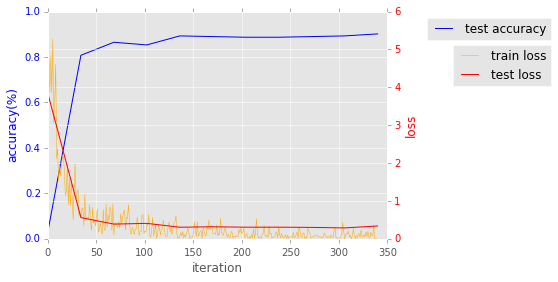

In [18]:
fig, ax1 = plt.subplots()
ax1.plot(test_its, test_accs, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy(%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.5,1))
ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, ls='-', lw=0.5, color='#ffaa00')
ax2.plot(test_its, test_losses, 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.5,0.88))
plt.tight_layout()
plt.show()

Now we achieved 90% accuracy in the validation data after 10 epochs. Let's classify one of the data.

In [19]:
def predict(x, top=5):
    x = x.reshape(1,3,227,227)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = zip(y_batch.data[0], label_names)
    results.sort(reverse=True)
    print 'results: '
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:10s} | {2:9.6f}%'.format(rank, name, float(score*100)))

label: Fritillary
results: 
# 1| Fritillary | 99.997917%
# 2| Dandelion  |  0.001617%
# 3| Sunflower  |  0.000349%
# 4| Daisy      |  0.000066%
# 5| Cowslip    |  0.000040%


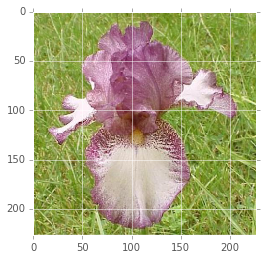

In [20]:
plt.imshow(imdeprocess(test_data[0]), interpolation='none')
print 'label: ' + label_names[test_labels[0]]
predict(test_data[0])